In [5]:
import sys

base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

In [10]:
from src.filler import fill_df, Debbuger, FillerHelper
from src.dataframe import read_data, windowing, show_error_metrics, split_data
from src.scaler import Scaler

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from keras.callbacks import EarlyStopping


In [7]:
df = read_data(f'{base_path}/data/daily_barbacena.csv')
df

,RADIATION,TEMP,HUMIDITY_h
Timestamp,,,
2003-03-21,17306.0,20.329167,81.375000
2003-03-22,10357.0,19.037500,88.250000
2003-03-23,10708.0,18.029167,89.250000
2003-03-24,12355.0,18.520833,87.958333
2003-03-25,19740.0,19.262500,80.958333
...,...,...,...
2022-12-27,13899.2,18.629167,88.958333
2022-12-28,10267.3,19.625000,88.500000
2022-12-29,8122.0,19.362500,92.208333


In [33]:
           
class LstmFillerModel:
    model: Sequential
    n_in: int = 5
    n_out: int = 1
    is_debug: bool = True
    random_state: int = 97423897
    scaler: MinMaxScaler

    def __init__(self, n_in=5, n_out=1, history_length=200, fill_without_retrain=30):
        self.n_in = n_in
        self.n_out = n_out
        self.history_length = history_length
        self.fill_without_retrain = fill_without_retrain

    def __windowing(self, values, step_back, step_front):
        x, y = [], []
        for i in range(len(values) - step_back - step_front):
            j = (i + step_back)
            x.append(values[i:j])
            y.append(values[j:(j+step_front)])
        return np.array(x), np.array(y)

    def __train(self, history):
        Debbuger.log(self.is_debug, 'History:',history)
        
        trainX, trainY = self.__windowing(values=history, step_back=self.n_in, step_front=self.n_out)

        Debbuger.log(self.is_debug, 'Shape trainX:', trainX.shape)
        self.model = Sequential([
            LSTM(320, input_shape=(self.n_in, 1), activation='relu', return_sequences=True),
            Dropout(rate=0.25),
            LSTM(units=180, activation='relu'),
            Dense(1, activation='relu')
        ])

        self.model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam())

        Debbuger.log(self.is_debug, 'Train Data:', trainX, trainY)
        self.model.fit(
                     trainX,
                     trainY,
                     epochs=200,
                     batch_size=32,
                     validation_split=0.1,
                     verbose=0,
                     callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)],
                     workers=4,
                     use_multiprocessing=True)
        

    def __fill(self, history):
        print('Length history:', len(history))
        x = np.array(history[-self.n_in:], dtype='object')\
            .astype(float)\
            .reshape(-1,1)
        xhat = self.scaler.transform(x)
        Debbuger.log(self.is_debug, 'xhat', xhat, xhat.shape)
        yhat = self.model.predict(xhat)[0]
        yhat = self.scaler.inverse_transform(yhat.reshape(-1, 1)).reshape(1, -1)[0][0]
        Debbuger.log(self.is_debug, 'Predict value:', yhat)
        return yhat


    def __init_model(self, dataserie: pd.Series):
        train_df = FillerHelper.get_largest_complete_interval(dataserie);
        self.scaler = MinMaxScaler(feature_range=(0,1))
        data = self.scaler.fit_transform(train_df.values.reshape(-1, 1))
        self.__train(data)


    def __update_history(self, history):
        length = min(200, len(history))
        return history[-length:]

    def filler(self, dataserie: pd.Series):
        dataserie_filled = dataserie.copy()

        self.__init_model(dataserie_filled)

        history = []

        filling = False
        fill_without_retrain = 0

        for i, r in enumerate(dataserie_filled):
            if pd.isna(r) or r is None:
                history = self.__update_history(history)
                
                new_value = self.__fill(history) 

                dataserie_filled.iloc[i] = new_value
                history.append(new_value)

                if filling:
                    Debbuger.log(self.is_debug, 'completando...')
                    fill_without_retrain += 1
                else:
                    Debbuger.log(self.is_debug, 'começando a completar...')
                    filling = True
            else:
                history.append(r)
                if filling:
                    Debbuger.log(self.is_debug, 'lacuna completada!')
                    filling = False
                    fill_without_retrain = 0
        return dataserie_filled

In [34]:
print('Quatidade de dados', len(df))
print(df.isna().sum())

filler = LstmFillerModel(n_in=5, n_out=1)
data = {}
for column in df.columns:
    data[column] = filler.filler(df[column])
    break
data =  pd.DataFrame(data=data, index=df.index.values)

print('Quatidade de dados', len(data))
print(data.isna().sum())

Quatidade de dados 7226
RADIATION     273
TEMP          326
HUMIDITY_h    667
dtype: int64
('History:', array([[0.23674653],
       [0.6023977 ],
       [0.71181119],
       ...,
       [0.43585346],
       [0.17824576],
       [0.23432082]]))
('Shape trainX:', (3120, 5, 1))
('Train Data:', array([[[0.23674653],
        [0.6023977 ],
        [0.71181119],
        [0.64866398],
        [0.58803814]],

       [[0.6023977 ],
        [0.71181119],
        [0.64866398],
        [0.58803814],
        [0.50055518]],

       [[0.71181119],
        [0.64866398],
        [0.58803814],
        [0.50055518],
        [0.47118693]],

       ...,

       [[0.45737401],
        [0.31277054],
        [0.47973843],
        [0.32947382],
        [0.40617772]],

       [[0.31277054],
        [0.47973843],
        [0.32947382],
        [0.40617772],
        [0.40639296]],

       [[0.47973843],
        [0.32947382],
        [0.40617772],
        [0.40639296],
        [0.43585346]]]), array([[[0.50055518]],

In [ ]:
dir = f'{base_path}/data-temp/lstm_with_random_forest_filler'
os.makedirs(dir, exist_ok=True)  
data.to_csv(f'{dir}/data_filled.csv')  

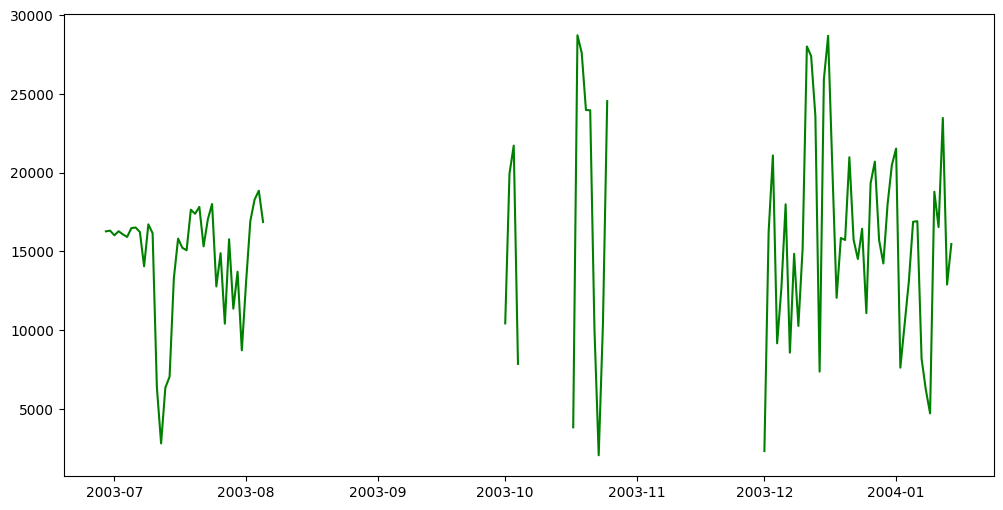

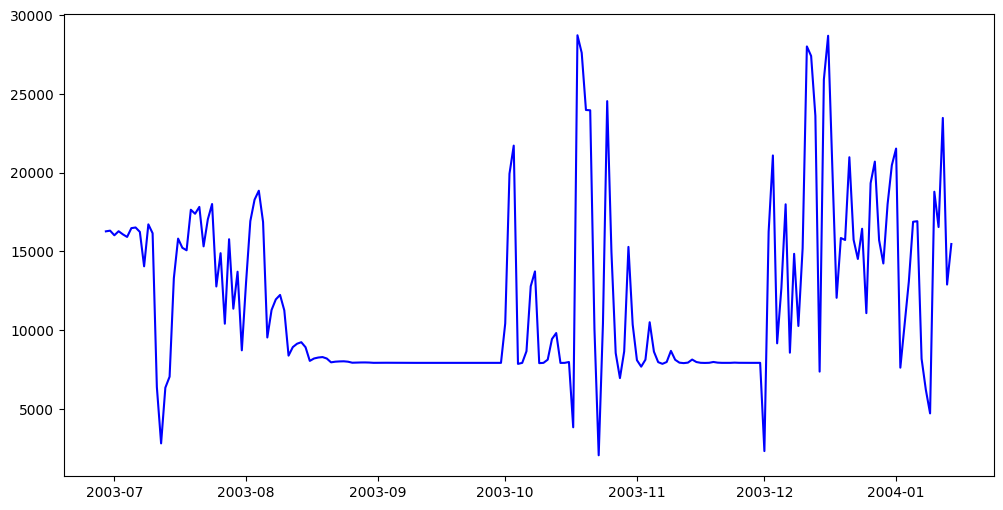

In [35]:
init = 100
m_range = 200

plt.figure(figsize=(12, 6))
plt.plot(df.RADIATION[init:init+m_range], color='green')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.RADIATION[init:init+m_range], color='blue')
plt.show()

In [ ]:
scaler = Scaler(data)
df_scaled = scaler.get_dataframe_scaled()
print(data, df_scaled)

            RADIATION       TEMP  HUMIDITY_h
Timestamp                                   
2003-03-21    17306.0  20.329167   81.375000
2003-03-22    10357.0  19.037500   88.250000
2003-03-23    10708.0  18.029167   89.250000
2003-03-24    12355.0  18.520833   87.958333
2003-03-25    19740.0  19.262500   80.958333
...               ...        ...         ...
2022-12-27    13899.2  18.629167   88.958333
2022-12-28    10267.3  19.625000   88.500000
2022-12-29     8122.0  19.362500   92.208333
2022-12-30     7987.6  18.958333   93.458333
2022-12-31    12501.4  18.854167   90.083333

[6546 rows x 3 columns]             RADIATION      TEMP  HUMIDITY_h
Timestamp                                  
2003-03-21   0.543153  0.600381    0.768722
2003-03-22   0.324396  0.536135    0.855255
2003-03-23   0.335446  0.485983    0.867841
2003-03-24   0.387294  0.510437    0.851584
2003-03-25   0.619777  0.547327    0.763478
...               ...       ...         ...
2022-12-27   0.435906  0.515826    0.8

In [ ]:
X, Y = windowing(df_scaled, 'RADIATION', 5, 1)
train_x, train_y, test_x, test_y = split_data(X, Y, length=len(df_scaled), ratio=0.9)

Epoch 1/200
58/58 - 3s - loss: 0.0314 - val_loss: 0.0291 - 3s/epoch - 53ms/step
Epoch 2/200
58/58 - 2s - loss: 0.0285 - val_loss: 0.0259 - 2s/epoch - 33ms/step
Epoch 3/200
58/58 - 2s - loss: 0.0256 - val_loss: 0.0230 - 2s/epoch - 35ms/step
Epoch 4/200
58/58 - 2s - loss: 0.0248 - val_loss: 0.0246 - 2s/epoch - 37ms/step
Epoch 5/200
58/58 - 2s - loss: 0.0244 - val_loss: 0.0229 - 2s/epoch - 36ms/step
Epoch 6/200
58/58 - 2s - loss: 0.0233 - val_loss: 0.0224 - 2s/epoch - 36ms/step
Epoch 7/200
58/58 - 2s - loss: 0.0232 - val_loss: 0.0221 - 2s/epoch - 39ms/step
Epoch 8/200
58/58 - 2s - loss: 0.0230 - val_loss: 0.0222 - 2s/epoch - 36ms/step
Epoch 9/200
58/58 - 2s - loss: 0.0233 - val_loss: 0.0219 - 2s/epoch - 40ms/step
Epoch 10/200
58/58 - 2s - loss: 0.0228 - val_loss: 0.0216 - 2s/epoch - 39ms/step
Epoch 11/200
58/58 - 2s - loss: 0.0229 - val_loss: 0.0224 - 2s/epoch - 35ms/step
Epoch 12/200
58/58 - 2s - loss: 0.0232 - val_loss: 0.0224 - 2s/epoch - 35ms/step
Epoch 13/200
58/58 - 2s - loss: 0.022

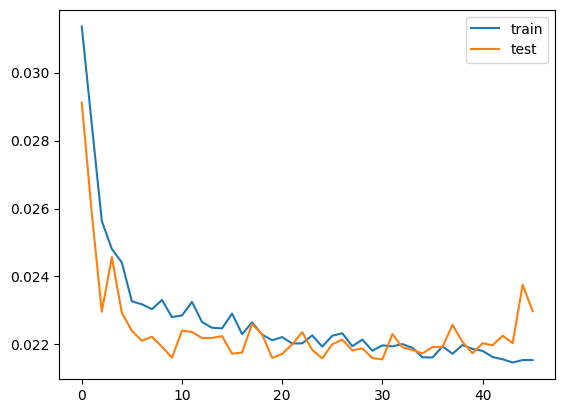

In [ ]:
model = Sequential([
    LSTM(units=352, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True, activation='relu'),
    Dropout(rate=0.35),
    LSTM(units=320, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.Adam(0.001))


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(train_x,
                     train_y,
                     epochs=200,
                     batch_size=72,
                     validation_split=0.3,
                     verbose=2,
                     callbacks=[es],
                     workers=4,
                     use_multiprocessing=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
predict = model.predict(test_x)

show_error_metrics(test_y.reshape(-1,1), predict)

real = scaler.scales['RADIATION'].inverse_transform(test_y.reshape(-1,1))
predict = scaler.scales['RADIATION'].inverse_transform(predict)

21/21 [==============================] - 0s 12ms/step
Test R2: 0.330
Test MSE: 0.025
Test RMSE: 0.157
Test MAE: 0.127
Test MAPE: 0.453


Test R2: 0.330
Test MSE: 24979104.486
Test RMSE: 4997.910
Test MAE: 4038.982
Test MAPE: 0.450


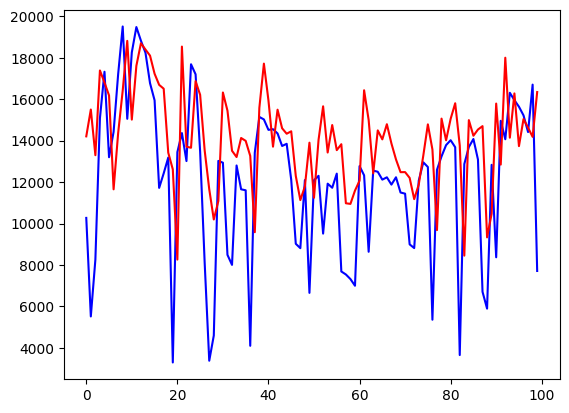

In [ ]:
range_plot = 100

plt.plot(real[0:range_plot], color='blue', label='real')
plt.plot(predict[0:range_plot], color='red', label='incompleto')

show_error_metrics(real, predict)

plt.show()